In [121]:
from cmp import *
% matplotlib notebook

<IPython.core.display.Javascript object>


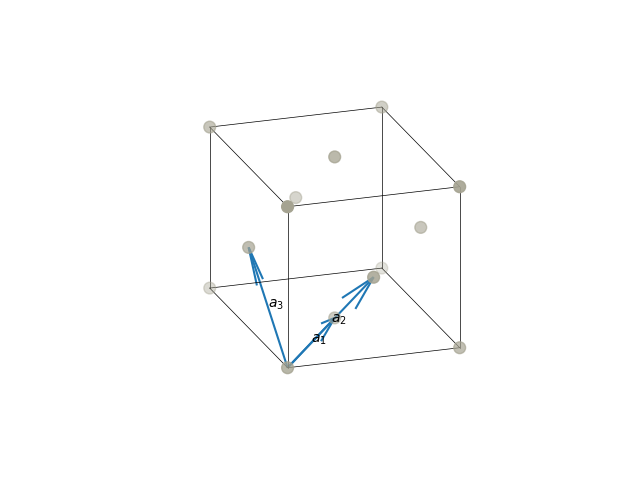

In [123]:
# Inputs

# Lattice vectors (3 vectors of length 3)
a = 1
b = 2
a1 = np.array([1, 0, 0])
a2 = np.array([0, 1, 0])
a3 = np.array([0, 0, 1])
theta = 80*np.pi/180

# Array of basis vectors
basis = np.array([[0,0,0],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5]])
# Colors for each of the basis vectors
colors = ('xkcd:cement','b','b','b')
# Size multiplier for each of the atoms. Default is 1
sizes = (2,1,1,1)


# Gridline type:
# Hard: lines along cartesian axes at integer spacings
# Soft: Lines along cartesian axes. Takes into account nonequal lattice spacing
# LatticeVectors: Lines along the latticevectors (only on lattice points)
GridType = "lattice"

# Limit type:
# Hard: Sets a hard limit on the plotting boundary (default  x = y = z = [0,2])
# Dynamic: Sets the limits as max(nx*a1,ny*a2,nz*a3), so we include nx unitcells in the a1 direction, etc.
# WDynamic: Sets the limits r_min = n_min*[a1 a2 a3] and likewise for n_max
LimType = "dynamic"
Maxs = [2,2,2]
Mins = [0,0,0]

latticelines = {'base centred cubic': 'soft',
                'base centred monoclinic 1': 'latticevectors',
                'base centred monoclinic 2': 'latticevectors',
                'base centred monoclinic 3': 'latticevectors',
                'bcc': 'soft',
                'conventional bcc': 'soft',
                'conventional fcc': 'soft',
                'fcc': 'soft',
                'hexagonal 1': 'latticevectors',
                'hexagonal 2': 'latticevectors',
                'orthorhombic': 'soft',
                'orthorhombic base centred': 'soft',
                'orthorhombic body centred': 'soft',
                'orthorhombic face centred': 'soft',
                'rhombohedral': 'latticevectors',
                'simple cubic': 'soft',
                'simple monoclinic': 'latticevectors',
                'tetragonal': 'soft',
                'tetragonal base centred': 'soft',
                'tetragonal body centred': 'soft',
                'tetragonal face centred': 'soft',
                'triclinic': 'latticevectors'}
LatticeType = "fcc"
GridType = latticelines[LatticeType]
(a1, a2, a3), basis = LatticeChooser(lattice_name=LatticeType)
R = RotMatrix()
a1, a2, a3, basis = rotate(a1,a2,a3,basis,R)

#LatticeCreator(a1,a2,a3,basis,colors,sizes,LimType,GridType,Mins,Maxs)
LatticeCreator(a1,a2,a3,basis,colors=["xkcd:cement","b","b","b"],LimType=LimType,Maxs=Maxs)

In [118]:
def rotate(a1, a2, a3, basis, R):
    """
    Rotates the lattice
    """
    return R@a1, R@a2, R@a3, (R@basis.T).T


def rotator(a1, a2, a3, basis, latticetype=None, verb=False):
    """
    Rotates the lattice to make plotting gridlines easier
    """
    # We remember, that |a x b| = |a| |b| sin(theta)
    eq = np.isclose
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    # Check for orthogonality
    ortho12 = eq(0, np.dot(a1, a2))
    ortho31 = eq(0, np.dot(a1, a3))
    ortho23 = eq(0, np.dot(a2, a3))

    if verb:
        print("Before:")
        print(a1)
        print(a2)
        print(a3)
        print(basis)

    if "hexagonal" in latticetype:
        a1, a2, a3, basis = rotateHex(a1, a2, a3, basis)
    elif latticetype == "fcc":
        a1, a2, a3, basis = rotatefcc(a1, a2, a3, basis)
    elif ortho12:
        # We choose a1 to align along x
        a1cross = np.cross(a1, x)
        theta = np.arcsin(mag(a1cross) / mag(a1))
        r1 = RotMatrix(a1cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)

        # Now we align a2 along y
        # But we gotta make sure we rotate in the right direction
        a2cross = np.cross(a2, y)
        sign = np.sign(a2cross)[0]
        theta = sign * np.arcsin(mag(a2cross) / mag(a2))
        r2 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)
    elif ortho23:
        # We choose a2 to align along x
        a2cross = np.cross(a2, x)
        theta = np.arcsin(mag(a2cross) / mag(a2))
        r2 = RotMatrix(a2cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)

        # Now we align a3 along y
        a3cross = np.cross(a3, y)
        sign = np.sign(a3cross)[0]
        theta = sign * np.arcsin(mag(a3cross) / mag(a3))
        r3 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r3)
    elif ortho31:
        # We choose a1 to align along x
        a1cross = np.cross(a1, x)
        theta = np.arcsin(mag(a1cross) / mag(a1))
        r1 = RotMatrix(a1cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)

        # Now we align a2 along y
        a3cross = np.cross(a3, y)
        sign = np.sign(a3cross)[0]
        theta = sign * np.arcsin(mag(a3cross) / mag(a3))
        r3 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r3)
    else:
        # Well, it doesn't really matter here, if none of them are orthogonal
        # to each other. We'll just use latticevector gridlines and leave this
        # be.
        pass

    # Let's sanitize the coordinates that are close to 0 (say if a1x =
    # 2*10^-10, then we set it equal 0)
    a1[eq(a1, 0)] = 0
    a2[eq(a2, 0)] = 0
    a3[eq(a3, 0)] = 0
    basis[eq(basis, 0)] = 0
    
    if verb:
        print("after")
        print(a1)
        print(a2)
        print(a3)
        print(basis)

    return a1, a2, a3, basis


In [120]:
R = RotMatrix()
#lattices = ["base centred cubic", "tetragonal face centred",
#            "tetragonal base centred", "orthorhombic base centred",
#            "orthorhombic face centred", "base centred monoclinic 1",
#            "base centred monoclinic 2", "base centred monoclinic 3"]

lattices = ["base centred monoclinic 1", "base centred monoclinic 2", "base centred monoclinic 3"]
for name in lattices:
    # Create the lattice
    lattice, basis = LatticeChooser(name)
    
    
    # rotate the lattice and basis
    lattice = (R@lattice.T).T
    basis = (R@basis.T).T
    a1,a2,a3 = lattice
    print(name)
    a1,a2,a3,basis = rotator(a1,a2,a3,basis,latticetype =name, verb=True)

base centred monoclinic 1
Before:
[ 0.80473785  0.50587936 -0.31061722]
[0.13336653 0.94986311 0.28279577]
[ 0.63793518 -0.21805321  0.73857396]
[0. 0. 0.]
after
[ 0.80473785  0.50587936 -0.31061722]
[0.13336653 0.94986311 0.28279577]
[ 0.63793518 -0.21805321  0.73857396]
[0. 0. 0.]
base centred monoclinic 2
Before:
[ 0.80473785  0.50587936 -0.31061722]
[0.13336653 0.94986311 0.28279577]
[ 1.27587036 -0.43610643  1.47714793]
[0. 0. 0.]
after
[ 0.80473785  0.50587936 -0.31061722]
[0.13336653 0.94986311 0.28279577]
[ 1.27587036 -0.43610643  1.47714793]
[0. 0. 0.]
base centred monoclinic 3
Before:
[ 0.80473785  0.50587936 -0.31061722]
[0.16940601 0.85649307 0.22410091]
[ 1.27587036 -0.43610643  1.47714793]
[0. 0. 0.]
after
[ 0.80473785  0.50587936 -0.31061722]
[0.16940601 0.85649307 0.22410091]
[ 1.27587036 -0.43610643  1.47714793]
[0. 0. 0.]


In [114]:
GridType = latticelines[latticetype]

{'simple cubic': 'soft', 'fcc': 'soft', 'bcc': 'soft', 'conventional fcc': 'soft', 'conventional bcc': 'soft', 'base centred cubic': 'soft', 'tetragonal': 'soft', 'tetragonal body centred': 'soft', 'tetragonal face centred': 'soft', 'tetragonal base centred': 'soft', 'orthorhombic': 'soft', 'orthorhombic base centred': 'soft', 'orthorhombic body centred': 'soft', 'orthorhombic face centred': 'soft', 'simple monoclinic': 'latticevectors', 'base centred monoclinic 1': 'latticevectors', 'base centred monoclinic 2': 'latticevectors', 'base centred monoclinic 3': 'latticevectors', 'hexagonal 1': 'latticevectors', 'hexagonal 2': 'latticevectors', 'triclinic': 'latticevectors', 'rhombohedral': 'latticevectors'}
